# Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [9]:
import cv2
import glob
import pickle
import numpy as np
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Spatial Features

In [3]:
img = cv2.imread("./data/vehicles/KITTI_extracted/47.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [4]:
color_spaces = ['HSV','LUV','HLS','YUV','Yrb','LAB']

def spatial_features(image, c_spaces):
    fig = plt.figure(figsize=(12, 12))
    for i, cspace in enumerate(c_spaces):
        
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'LAB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        elif cspace == 'Yrb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        
        # display images
        for p, c in enumerate(cspace,1):
            channel = feature_image[:,:,p-1]
                
            ax = fig.add_subplot(6,3,i*3+p)
    
            ax.set_title(c)
            ax.imshow(channel, cmap='gray')
            
    plt.tight_layout()
    plt.show()

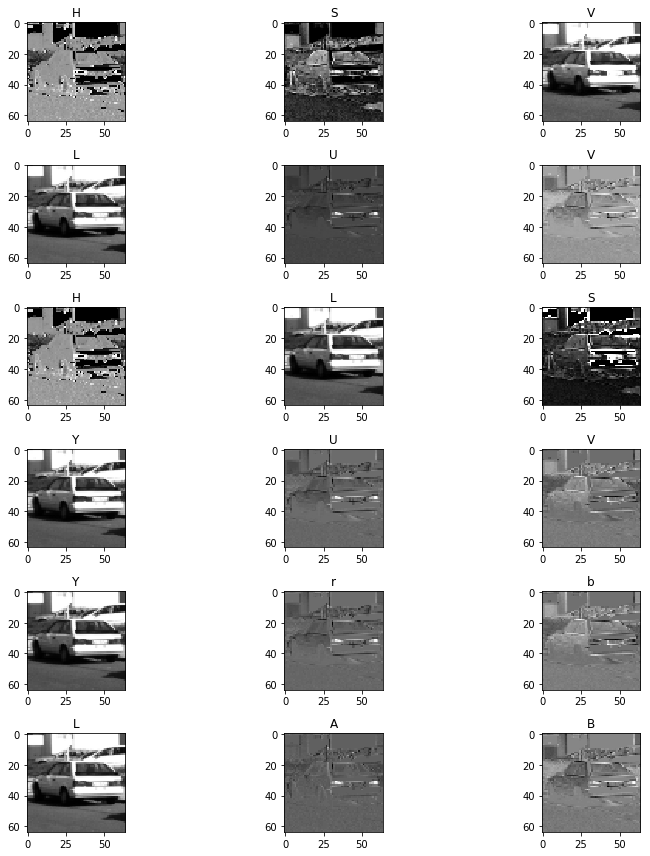

In [5]:
spatial_features(img, color_spaces)

In [6]:
img2 = cv2.imread("./data/vehicles/KITTI_extracted/74.png")
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

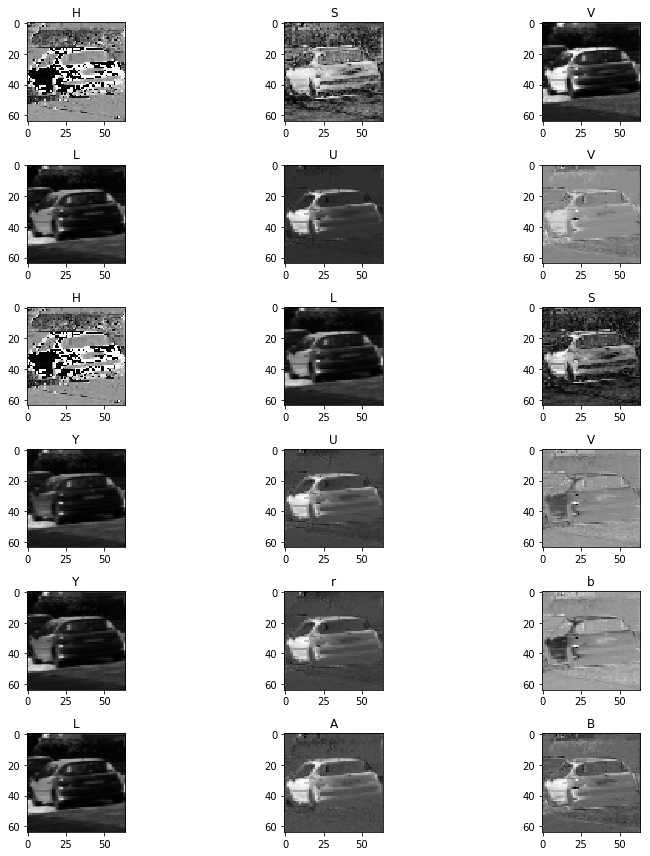

In [7]:
spatial_features(img2, color_spaces)

## Histogram Features

In [2]:
def color_hist(image_rgb, image_hsv):
    rhist = np.histogram(image_rgb[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image_rgb[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image_rgb[:,:,2], bins=32, range=(0, 256))
    hhist = np.histogram(image_hsv[:,:,0], bins=32, range=(0, 181))
    shist = np.histogram(image_hsv[:,:,1], bins=32, range=(0, 256))

    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    bin_edges_h = hhist[1]
    bin_centers_h = (bin_edges_h[1:]  + bin_edges_h[0:len(bin_edges_h)-1])/2

    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(231)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(232)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(233)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    plt.subplot(234)
    plt.bar(bin_centers_h, hhist[0])
    plt.xlim(0, 180)
    plt.title('H Histogram')
    plt.subplot(235)
    plt.bar(bin_centers, shist[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.tight_layout()

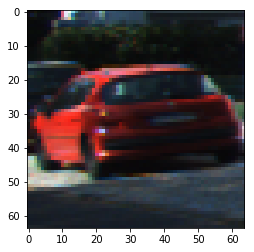

In [3]:
image = cv2.imread("./data/vehicles/KITTI_extracted/74.png")
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(image_rgb)

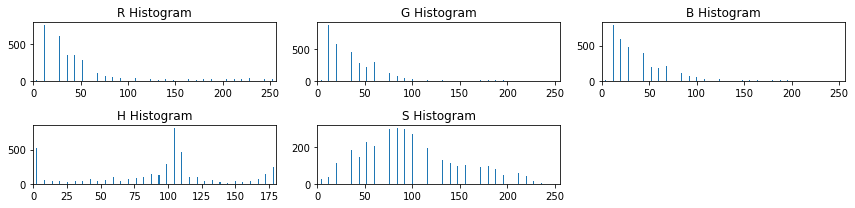

In [5]:
color_hist(image_rgb, image_hsv)

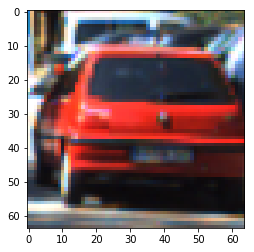

In [20]:
image = cv2.imread("./data/vehicles/KITTI_extracted/150.png")
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(image_rgb)

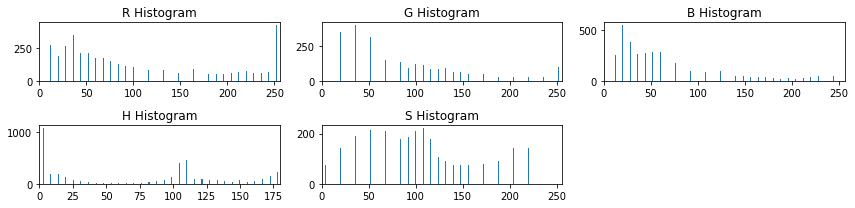

In [21]:
color_hist(image_rgb, image_hsv)

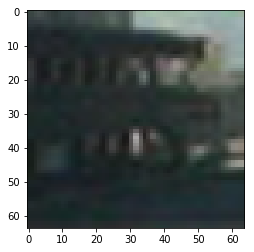

In [4]:
image = cv2.imread("./data/non-vehicles/GTI/image227.png")
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(image_rgb)

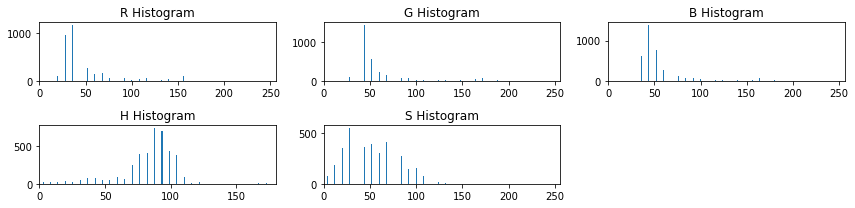

In [5]:
color_hist(image_rgb, image_hsv)

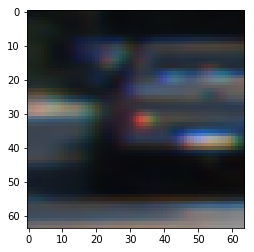

In [6]:
image = cv2.imread("./data/vehicles/KITTI_extracted/46.png")
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(image_rgb)

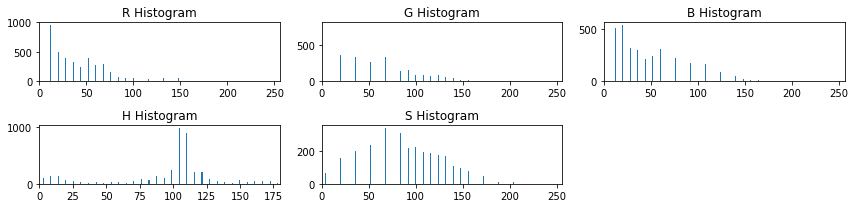

In [7]:
color_hist(image_rgb, image_hsv)

As expected, H and S channels are giving better results in color space feature due their minimal variance under different lighting conditions.

## HOG Features

In [87]:
def hog_vis(img, pix_per_cell, cell_per_block, orient, cspace='HSV', transform=False):
    
    fig = plt.figure()
    for i, channel in enumerate(cspace):

        hog_features, hog_image = hog(img[:,:,i], orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, transform_sqrt=transform, feature_vector=False,
                                  block_norm="L2-Hys")
        
        ax = fig.add_subplot(1,3,i+1)
    
        ax.set_title(channel)
        ax.imshow(hog_image, cmap='gray')
            
    plt.tight_layout()
    plt.show()

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


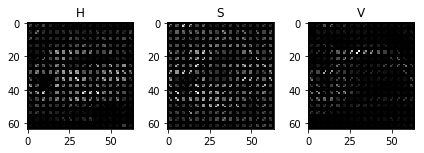

In [23]:
pix_per_cell = 4
cell_per_block = 2
orient = 8

image = cv2.imread("./data/vehicles/KITTI_extracted/74.png")
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# transform_sqrt False, 3 cells per block
hog_vis(image_hsv, pix_per_cell, cell_per_block, orient, cspace='HSV', transform=False)

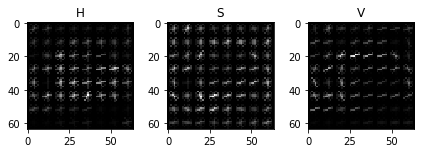

In [15]:
# transform_sqrt True, 3 cells per block
hog_vis(image_hsv, pix_per_cell, cell_per_block, orient, cspace='HSV', transform=True)

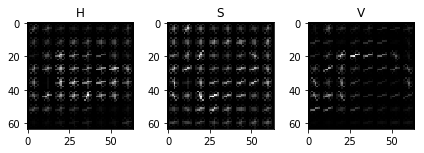

In [16]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

# transform_sqrt False, 2 cells per block
hog_vis(image_hsv, pix_per_cell, cell_per_block, orient, cspace='HSV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


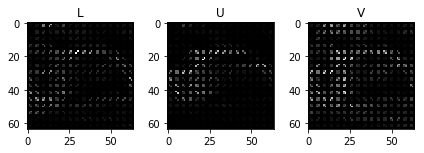

In [22]:
pix_per_cell = 4
cell_per_block = 2
orient = 8

image = cv2.imread("./data/vehicles/KITTI_extracted/74.png")
image_luv = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)

# transform_sqrt False, 2 cells per block
hog_vis(image_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


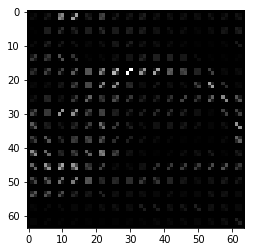

In [12]:
pix_per_cell = 4
cell_per_block = 2
orient = 8



img = cv2.imread("./data/vehicles/KITTI_extracted/74.png")
img_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)

hog_features, hog_image = hog(img_luv, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, transform_sqrt=False,block_norm=None,
                                  feature_vector=True,multichannel=True)
           
plt.imshow(hog_image, cmap='gray')

In [15]:
hog_features.shape

(7200,)

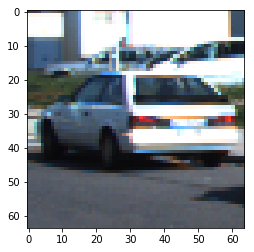

In [7]:
image2 = cv2.imread("./data/vehicles/KITTI_extracted/47.png")
image2_hsv = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.imshow(image2_rgb)

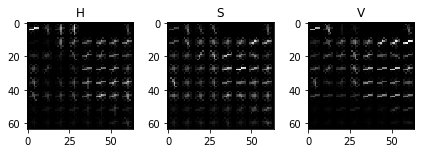

In [19]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

# transform_sqrt False, 2 cells per block
hog_vis(image2_hsv, pix_per_cell, cell_per_block, orient, cspace='HSV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


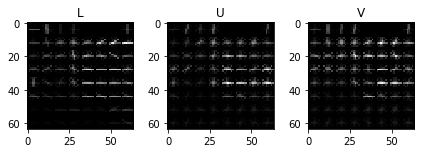

In [5]:
image2 = cv2.imread("./data/vehicles/KITTI_extracted/47.png")
image2_luv = cv2.cvtColor(image2, cv2.COLOR_BGR2LUV)

pix_per_cell = 8
cell_per_block = 2
orient = 9

# transform_sqrt False, 2 cells per block
hog_vis(image2_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


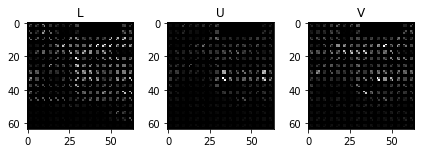

In [34]:
image2 = cv2.imread("./data/vehicles/KITTI_extracted/47.png")
image2_luv = cv2.cvtColor(image2, cv2.COLOR_BGR2LUV)

pix_per_cell = 4
cell_per_block = 2
orient = 8

# transform_sqrt False, 2 cells per block
hog_vis(image2_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=False)

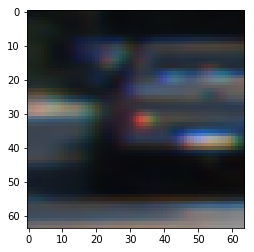

In [98]:
image3 = cv2.imread("./data/vehicles/KITTI_extracted/46.png")
image_rgb = cv2.cvtColor(image3,cv2.COLOR_BGR2RGB)
image_luv = cv2.cvtColor(image3, cv2.COLOR_BGR2LUV)

plt.imshow(image_rgb)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


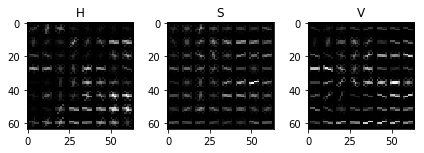

In [89]:
image3_hsv = cv2.cvtColor(image3,cv2.COLOR_BGR2HSV)
hog_vis(image3_hsv, 8, 2, 12, cspace='HSV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


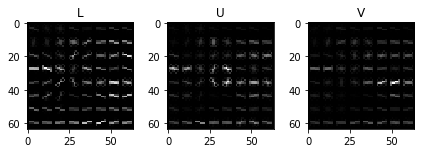

In [99]:
pix_per_cell = 8
cell_per_block = 2
orient = 12

# transform_sqrt False, 2 cells per block
hog_vis(image_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


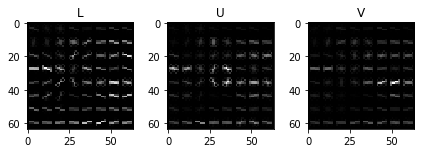

In [113]:
pix_per_cell = 8
cell_per_block = 3
orient = 12

# transform_sqrt False, 4 cells per block
hog_vis(image_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


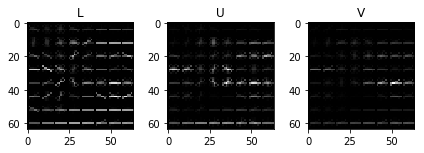

In [11]:
hog_vis(image_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=True)

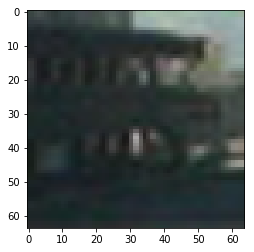

In [96]:
image_nv = cv2.imread("./data/non-vehicles/GTI/image227.png")
image_nv_rgb = cv2.cvtColor(image_nv,cv2.COLOR_BGR2RGB)
image_nv_luv = cv2.cvtColor(image_nv, cv2.COLOR_BGR2LUV)

plt.imshow(image_nv_rgb)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


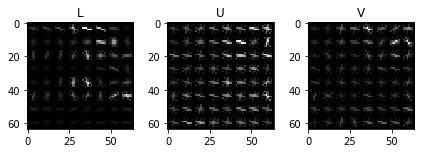

In [112]:
pix_per_cell = 8
cell_per_block = 2
orient = 12

hog_vis(image_nv_luv, pix_per_cell, cell_per_block, orient, cspace='LUV', transform=False)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


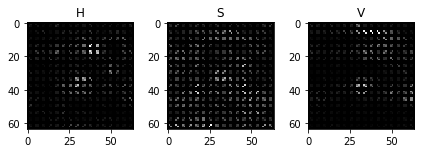

In [110]:
pix_per_cell = 4
cell_per_block = 3
orient = 12

image_nv_hsv = cv2.cvtColor(image_nv,cv2.COLOR_BGR2HSV)
hog_vis(image_nv_hsv, pix_per_cell, cell_per_block, orient, cspace='HSV', transform=False)

In light of exploration of spatial, color histogram and histogram of gradient features, I have decided to use LUV color space as it provides the most distinct features across vehicle and non-vehicle images.

## Combine Features

In [2]:
def bin_spatial(img, size=(32, 32)):
    """
    Unravels image dimensions into a 1D array.
    """
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Calculates histogram for each channel of an image.
    """

    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

def get_hog_features(image, orient, pix_per_cell, cell_per_block, 
                     feature_vec=True, vis=False, transform_sqrt=False):
    """
    Calculates the histogram of gradient for given image channel for given 
    pixel per cell, cell per block and orientation parameters.
    If feature_vec parameter is set to True, function will return gradient features
    as a 1D vector. 
    If vis parameter is set to True, function will return an image representation
    along with the feature vector.
    """

    
    return_list = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=transform_sqrt, visualise= vis, feature_vector= feature_vec)
    
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return return_list

# Define a function to extract features from an images
# Have this function call bin_spatial() and color_hist()
def extract_features(image,orient, pix_per_cell, cell_per_block, hog_channel, cspace, spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256)):
    """
    Combines spatial, color histogram and histogram of gradient features.
    Returns a combined 1D feature vector.
    """

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)
            
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Apply get_hog_features
    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                    feature_vec=True, vis=False)
    
    # Return list of feature vectors
    return np.concatenate((spatial_features, hist_features, hog_features))

## Load Data Set

In [114]:
# Collect vehicle image paths
vehicle_img = glob.glob('*data/vehicles/*/*')
vehicle_features = []
# Set feature calculation arguments
pix_per_cell = 8
cell_per_block = 2
orient = 12
hog_channel = 1
spatial_size=(32, 32)
cspace='LUV'
# Collect vehicle image features for training
for image in vehicle_img:
    image_cpy = cv2.imread(image)
    image_rgb = cv2.cvtColor(image_cpy, cv2.COLOR_BGR2RGB)
    features = extract_features(image_rgb,orient, pix_per_cell, cell_per_block, hog_channel, cspace, spatial_size)
    vehicle_features.append(features)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [115]:
# Collect non-vehicle image paths
non_vehicle_img = glob.glob('*data/non-vehicles/*/*')
non_vehicle_features = []
# Collect non-vehicle image features for training
for image in non_vehicle_img:
    image_cpy = cv2.imread(image)
    image_rgb = cv2.cvtColor(image_cpy, cv2.COLOR_BGR2RGB)
    features = extract_features(image_rgb,orient, pix_per_cell, cell_per_block, hog_channel, cspace, spatial_size)
    non_vehicle_features.append(features)

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [116]:
print("Length of vehicles data set: {0}".format(len(vehicle_features)))
print("Length of non_vehicles data set: {0}".format(len(non_vehicle_features)))
print("Length of feature vector: {0}".format(len(non_vehicle_features[0])))

Length of vehicles data set: 8792
Length of non_vehicles data set: 8968
Length of feature vector: 7056


## Train SVM Classifier

In [117]:
# Stack features vertically
data_X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# Create labels
labels = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

In [118]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(data_X, labels, test_size=0.2, random_state=rand_state)

In [119]:
# Scale training and test sets separately
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [120]:
import time

# Train linear SVM model
svc = LinearSVC(loss='hinge')
t=time.time()
# Train the SVC
svc.fit(scaled_X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC')
print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))

10.54 Seconds to train SVC
Test Accuracy of SVC =  0.9819819819819819


In [121]:
# Save model and parameters
import pickle

model_pickle = { "svc": svc, "scaler": X_scaler, "orient": orient, "pix_per_cell": pix_per_cell,
               "cell_per_block": cell_per_block, "spatial_size": spatial_size, "color_space": cspace}

pickle.dump( model_pickle, open( "save2.p", "wb" ) )

## Window Search

In [113]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, hog_channel, color_space, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=4, cell_per_block=2):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img,orient, pix_per_cell, cell_per_block, hog_channel=hog_channel, cspace=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


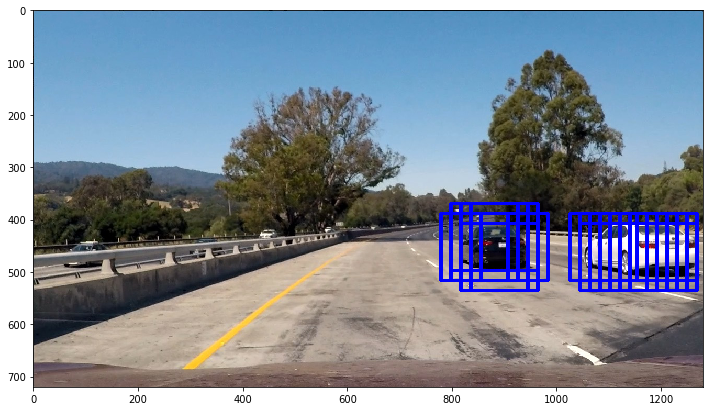

In [14]:
# Test Window serach on test image
image = cv2.imread('test_images/test1.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image_rgb)

pix_per_cell = 8
cell_per_block = 2
orient = 12
hog_channel = 1
spatial_size=(32, 32)
cspace='LUV'
y_start_stop =[350, 650]

windows = slide_window(image_rgb, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))

hot_windows = search_windows(image_rgb, windows, svc, X_scaler, hog_channel=hog_channel, color_space=cspace, 
                    spatial_size=spatial_size, hist_bins=32, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

fig = plt.figure(figsize=(12,8))
plt.imshow(window_img)

## HOG Sub-sampling

In [18]:
# Collect model parameters
model_pickle = pickle.load(open("save.p", "rb"))

svc = model_pickle["svc"]
X_scaler = model_pickle["scaler"]
orient = model_pickle["orient"]
pix_per_cell = model_pickle["pix_per_cell"]
cell_per_block = model_pickle["cell_per_block"]
spatial_size = model_pickle["spatial_size"]
colorspace = model_pickle["color_space"]
hist_bins = 32

In [3]:
def convert_color(img, conv='RGB2LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step):
    # Array to hold box coordinates for identified cars
    boxes=[]
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    #hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat2

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return boxes, draw_img

C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\AOZ001\AppData\Local\Continuum\Anaconda3\envs\tflow\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


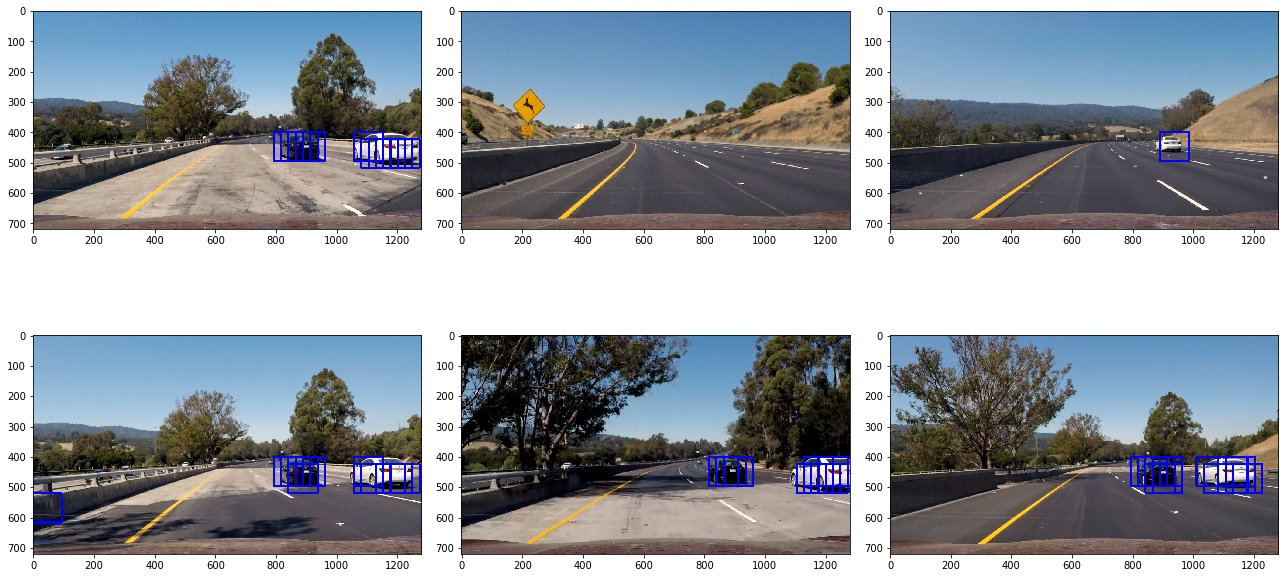

In [12]:
ystart = 400
ystop = 656
scale = 1.5
step = 2

test_img = glob.glob('test_images/*')
fig = plt.figure(figsize=(18,10))
for i, path in enumerate(test_img):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _, out_img = find_cars(image_rgb, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step)
    
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(out_img)
            
plt.tight_layout()
plt.show()


## Managing False Positives and Duplicates

In [4]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map        
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

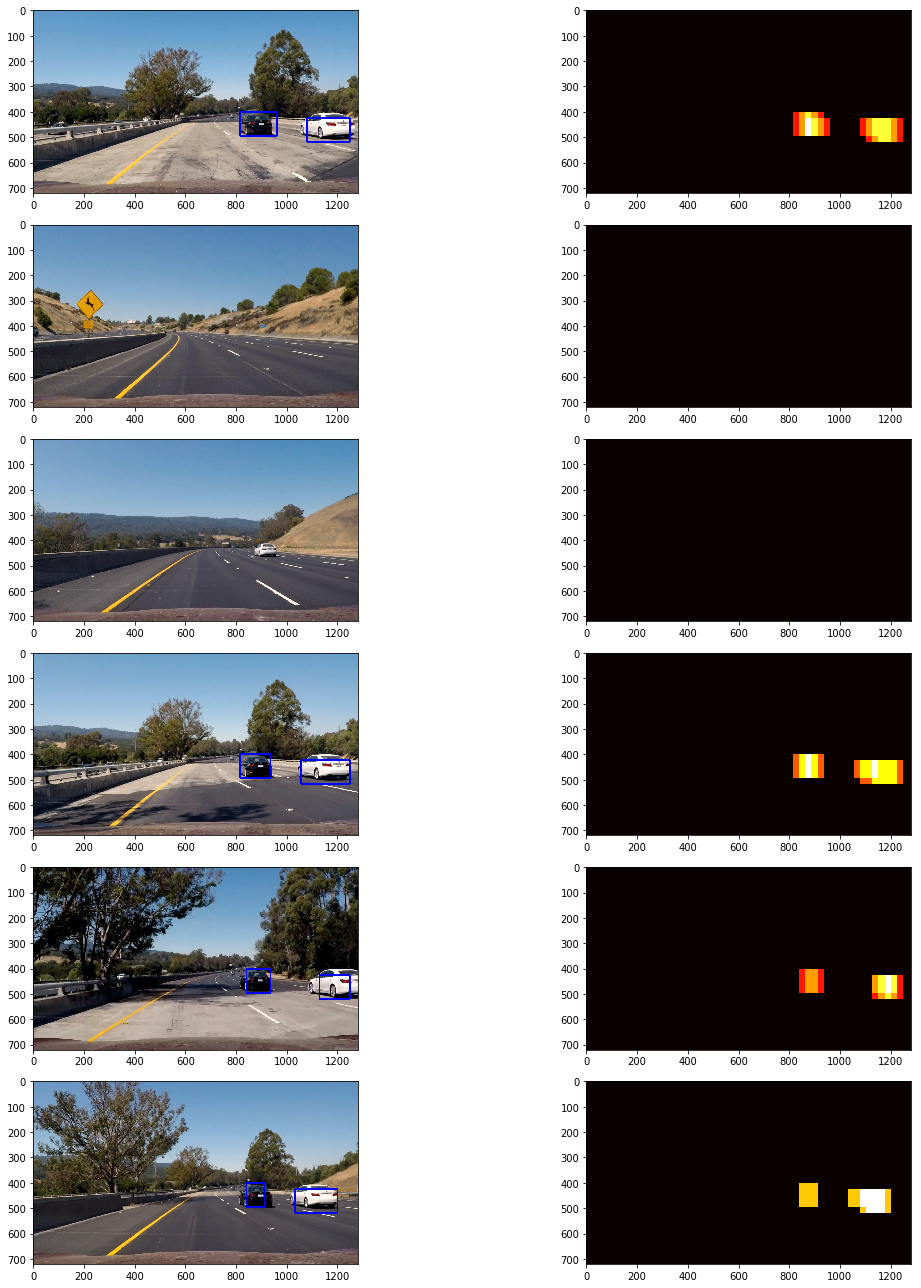

In [30]:
ystart = 400
ystop = 656
scale = 1.5
step = 2

test_img = glob.glob('test_images/*')
fig, ax = plt.subplots(6,2,figsize=(18, 18))

for i, path in enumerate(test_img):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    box_list, _ = find_cars(image_rgb, ystart, ystop, scale, svc, X_scaler, 
                                  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image_rgb), labels)
    
    ax[i,0].imshow(draw_img)
    ax[i,1].imshow(heatmap, cmap='hot')
            
plt.tight_layout()
plt.show()

## Video Pipeline

In [1]:
import cv2
import glob
import pickle
import numpy as np
import lanedetection
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
# Collect model parameters
model_pickle = pickle.load(open("save.p", "rb"))

svc = model_pickle["svc"]
X_scaler = model_pickle["scaler"]
orient = model_pickle["orient"]
pix_per_cell = model_pickle["pix_per_cell"]
cell_per_block = model_pickle["cell_per_block"]
spatial_size = model_pickle["spatial_size"]
colorspace = model_pickle["color_space"]

In [3]:
def bin_spatial(img, size=(32, 32)):
    """
    Unravels image dimensions into a 1D array.
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Calculates histogram for each channel of an image.
    """

    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

def get_hog_features(image, orient, pix_per_cell, cell_per_block, 
                     feature_vec=True, vis=False, transform_sqrt=False):
    """
    Calculates the histogram of gradient for given image channel for given 
    pixel per cell, cell per block and orientation parameters.
    If feature_vec parameter is set to True, function will return gradient features
    as a 1D vector. 
    If vis parameter is set to True, function will return an image representation
    along with the feature vector.
    """

    
    return_list = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=transform_sqrt, visualise= vis, feature_vector= feature_vec)
    
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return return_list
    
def convert_color(img, conv='RGB2LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step):
    # Array to hold box coordinates for identified cars
    boxes=[]
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    #hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat2

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return boxes, draw_img

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map        
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [5]:
def id_cars(image, lane_output, svc, X_scaler, orient, pix_per_cell, cell_per_block,
             spatial_size, colorspace, hist_bins, threshold, scales, areas):
    
    box_list = []
    
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    step = 1
    for scale, area in zip(scales, areas):

        boxes, _ = find_cars(image, area[0], area[1], scale, svc, X_scaler, 
                                  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step)
        # Increase step to look for closer vehicles
        step +=1
        box_list.extend(boxes)
        
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(lane_output), labels)
    
    return draw_img

In [6]:
# Set search parameters
hist_bins = 32
scales =[1.2, 1.5, 2]
areas = [[400,500],[400,500], [400,656]]
threshold = 3

In [7]:
def process_image(img):
    """
    Pipeline for overlaying detected lane and vehicle information on an image.
    """
    lane_output = lanedetection.process_img(img)
    overlay = id_cars(img, lane_output, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                      spatial_size, colorspace, hist_bins, threshold, scales, areas)
    
    return overlay

In [8]:
def video_pipeline(input_vid, output_vid):
    
    clip = VideoFileClip(input_vid)
    
    processor = clip.fl_image(process_image)
    processor.write_videofile(output_vid, audio=False)
    
    processor.reader.close()

In [9]:
from moviepy.editor import VideoFileClip

video_pipeline('project_video.mp4', 'output_video/project_output.mp4')

[MoviePy] >>>> Building video output_video/project_output.mp4
[MoviePy] Writing video output_video/project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:02<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_output.mp4 

